In [ ]:
# 페이스북(현 메타)에서 만든 시계열 데이터 예측 패키지
!pip install prophet --quiet

In [ ]:
!pip install pyupbit --quiet # 업비트에서 제공하는 API (가격, 거래)

In [ ]:
!pip install finance-datareader --quiet # 주식 데이터

In [ ]:
# Python
import pandas as pd # pandas
from prophet import Prophet # prophet -> Prophet
import pyupbit
# import FinanceDataReader as fdr

In [ ]:
# df = fdr.DataReader('O')
# df.tail()

In [ ]:
# pyupbit.get_ohlcv() # 200일치 KRW-BTC (원-비트코인)
# pyupbit.get_ohlcv("KRW-ETH") # 200일치 KRW-ETH (원-이더리움)
# pyupbit.get_ohlcv("KRW-BTC", interval='minutes60') # 200시간치 KRW-BTC
# 365일 * 24시간치의 KRW-BTC
pyupbit.get_ohlcv("KRW-BTC", interval='minutes60', count=24 * 365)

,open,high,low,close,volume,value
2021-11-23 04:00:00,70917000.0,71584000.0,70384000.0,70456000.0,287.965506,2.036699e+10
2021-11-23 05:00:00,70456000.0,70970000.0,70355000.0,70502000.0,180.165468,1.272852e+10
2021-11-23 06:00:00,70502000.0,70980000.0,70285000.0,70786000.0,243.018092,1.714706e+10
2021-11-23 07:00:00,70786000.0,71193000.0,70694000.0,71086000.0,198.542689,1.407509e+10
2021-11-23 08:00:00,71086000.0,71123000.0,70562000.0,70589000.0,345.680914,2.448014e+10
...,...,...,...,...,...,...
2022-11-23 08:00:00,22538000.0,22616000.0,22509000.0,22584000.0,126.649070,2.857764e+09
2022-11-23 09:00:00,22599000.0,22619000.0,22525000.0,22565000.0,210.076677,4.741139e+09
2022-11-23 10:00:00,22566000.0,22650000.0,22530000.0,22647000.0,142.695841,3.224167e+09
2022-11-23 11:00:00,22647000.0,22985000.0,22639000.0,22947000.0,483.346266,1.104806e+10


In [ ]:
# df = pyupbit.get_ohlcv(interval='day', count=365)
# df = pyupbit.get_ohlcv(interval='minute60', count=365 * 24 * 3)
# 한국원화-비트코인 / 1시간치 / 365일 24시간 3년 -> 3년치 1시간 데이터
df = pyupbit.get_ohlcv(ticker="KRW-BTC", interval='minute60', count=365 * 24 * 3)
df.tail()

,open,high,low,close,volume,value
2022-11-23 08:00:00,22538000.0,22616000.0,22509000.0,22584000.0,126.649070,2.857764e+09
2022-11-23 09:00:00,22599000.0,22619000.0,22525000.0,22565000.0,210.076677,4.741139e+09
2022-11-23 10:00:00,22566000.0,22650000.0,22530000.0,22647000.0,142.695841,3.224167e+09
2022-11-23 11:00:00,22647000.0,22985000.0,22639000.0,22947000.0,483.346266,1.104806e+10
2022-11-23 12:00:00,22941000.0,22966000.0,22898000.0,22919000.0,64.257014,1.472700e+09


ds : 데이터의 시간 값 (index)<br>
y : 변동되는 대상이 되는 값 (close)

In [ ]:
df['ds'] = df.index
df.tail()

,open,high,low,close,volume,value,ds
2022-11-23 08:00:00,22538000.0,22616000.0,22509000.0,22584000.0,126.649070,2.857764e+09,2022-11-23 08:00:00
2022-11-23 09:00:00,22599000.0,22619000.0,22525000.0,22565000.0,210.076677,4.741139e+09,2022-11-23 09:00:00
2022-11-23 10:00:00,22566000.0,22650000.0,22530000.0,22647000.0,142.695841,3.224167e+09,2022-11-23 10:00:00
2022-11-23 11:00:00,22647000.0,22985000.0,22639000.0,22947000.0,483.346266,1.104806e+10,2022-11-23 11:00:00
2022-11-23 12:00:00,22941000.0,22966000.0,22898000.0,22919000.0,64.257014,1.472700e+09,2022-11-23 12:00:00


In [ ]:
# shift -> 1 / -1
# 1        NULL
# 2   ->     1
# 3          2
# 현재 종가 / 1시간 전 종가
df['y'] = df['close'] / df['close'].shift(1) # 상승률
# df['y'] = df['close']

In [ ]:
df.tail()

,open,high,low,close,volume,value,ds,y
2022-11-23 08:00:00,22538000.0,22616000.0,22509000.0,22584000.0,126.649070,2.857764e+09,2022-11-23 08:00:00,1.001952
2022-11-23 09:00:00,22599000.0,22619000.0,22525000.0,22565000.0,210.076677,4.741139e+09,2022-11-23 09:00:00,0.999159
2022-11-23 10:00:00,22566000.0,22650000.0,22530000.0,22647000.0,142.695841,3.224167e+09,2022-11-23 10:00:00,1.003634
2022-11-23 11:00:00,22647000.0,22985000.0,22639000.0,22947000.0,483.346266,1.104806e+10,2022-11-23 11:00:00,1.013247
2022-11-23 12:00:00,22941000.0,22966000.0,22898000.0,22919000.0,64.257014,1.472700e+09,2022-11-23 12:00:00,0.998780


In [ ]:
# Python
m = Prophet() # 객체 (Model)
m.fit(df) # ds, y

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkn1dx23k/d1qvt849.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkn1dx23k/yij3eyr0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12263', 'data', 'file=/tmp/tmpkn1dx23k/d1qvt849.json', 'init=/tmp/tmpkn1dx23k/yij3eyr0.json', 'output', 'file=/tmp/tmpkn1dx23k/prophet_modelfd4c6v2_/prophet_model-20221123032306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:23:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:23:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=24,
                                 freq='H' # H : 시간
                                 # D : 일자
                                 ) # 예측하고 싶은 단위 길이
# predict : 예측
forecast = m.predict(future)

In [ ]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
26299,2022-11-24 08:00:00,0.999631,0.989516,1.008257,0.999631,0.999631,-0.000157,-0.000157,-0.000157,-0.000158,...,0.000081,0.000081,0.000081,-0.000080,-0.000080,-0.000080,0.0,0.0,0.0,0.999474
26300,2022-11-24 09:00:00,0.999631,0.989923,1.008511,0.999631,0.999631,-0.000356,-0.000356,-0.000356,-0.000345,...,0.000070,0.000070,0.000070,-0.000081,-0.000081,-0.000081,0.0,0.0,0.0,0.999275
26301,2022-11-24 10:00:00,0.999631,0.989924,1.007856,0.999631,0.999631,-0.000451,-0.000451,-0.000451,-0.000427,...,0.000058,0.000058,0.000058,-0.000082,-0.000082,-0.000082,0.0,0.0,0.0,0.999179
26302,2022-11-24 11:00:00,0.999631,0.989809,1.008368,0.999631,0.999631,-0.000484,-0.000484,-0.000484,-0.000447,...,0.000046,0.000046,0.000046,-0.000083,-0.000083,-0.000083,0.0,0.0,0.0,0.999147
26303,2022-11-24 12:00:00,0.999631,0.989929,1.008178,0.999631,0.999631,-0.000469,-0.000469,-0.000469,-0.000419,...,0.000034,0.000034,0.000034,-0.000084,-0.000084,-0.000084,0.0,0.0,0.0,0.999161


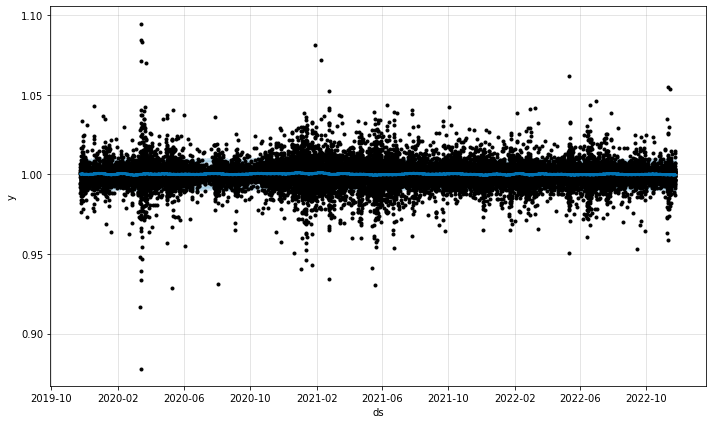

In [ ]:
fig1 = m.plot(forecast)

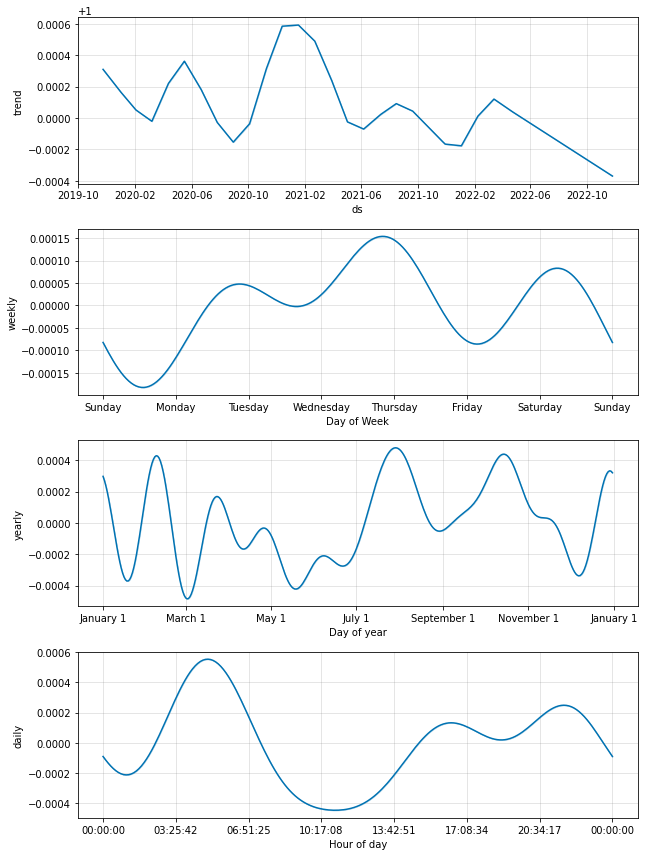

In [ ]:
fig2 = m.plot_components(forecast)